In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam

2024-09-05 15:12:38.864092: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 15:12:38.871427: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 15:12:38.898725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 15:12:38.941916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 15:12:38.954933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 15:12:41.705740: W tensorflow/compiler/tf2tensorrt/utils/p

In [2]:
meteo_df = pd.read_csv("./data/Final_Open_Meteo_without_Nan.csv").drop('Unnamed: 0', axis=1)

In [3]:
meteo_df.head()

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,2010-01-01,53.0,25.2,17.8,21.1,27.8,19.2,22.9,2010-01-01T03:27,2010-01-01T15:46,...,5.0,6.1,20.5,82.0,3.12,-3.339192,36.596603,1416.0,Tanzania,Arusha
1,2010-01-02,61.0,25.7,16.8,20.5,27.8,18.3,22.3,2010-01-02T03:28,2010-01-02T15:46,...,15.0,9.2,28.1,17.0,3.20,-3.339192,36.596603,1416.0,Tanzania,Arusha
2,2010-01-03,55.0,25.7,16.7,20.4,28.2,18.0,22.3,2010-01-03T03:28,2010-01-03T15:47,...,10.0,8.6,31.7,34.0,3.51,-3.339192,36.596603,1416.0,Tanzania,Arusha
3,2010-01-04,61.0,25.1,16.3,20.3,27.8,17.6,21.8,2010-01-04T03:29,2010-01-04T15:47,...,5.0,13.3,33.8,45.0,3.32,-3.339192,36.596603,1416.0,Tanzania,Arusha
4,2010-01-05,51.0,26.4,14.7,21.1,29.0,15.4,22.5,2010-01-05T03:29,2010-01-05T15:48,...,3.0,10.2,30.6,41.0,4.20,-3.339192,36.596603,1416.0,Tanzania,Arusha


In [4]:
meteo_df.isna().sum()

time                          0
weathercode                   0
temperature_2m_max            0
temperature_2m_min            0
temperature_2m_mean           0
apparent_temperature_max      0
apparent_temperature_min      0
apparent_temperature_mean     0
sunrise                       0
sunset                        0
shortwave_radiation_sum       0
precipitation_sum             0
rain_sum                      0
snowfall_sum                  0
precipitation_hours           0
windspeed_10m_max             0
windgusts_10m_max             0
winddirection_10m_dominant    0
et0_fao_evapotranspiration    0
latitude                      0
longitude                     0
elevation                     0
country                       0
city                          0
dtype: int64

In [5]:
meteo_df.duplicated().sum()

0

In [6]:
meteo_df.shape

(121922, 24)

In [7]:
meteo_df.city.value_counts()

city
Arusha            5301
Morogoro          5301
Zanzibar South    5301
Tanga             5301
Tabora            5301
Shinyanga         5301
Pwani             5301
Pemba             5301
Njombe            5301
Mwanza            5301
Mtwara            5301
Mbeya             5301
Dar es Salaam     5301
Mara              5301
Manyara           5301
Lindi             5301
Kilimanjaro       5301
Kigoma            5301
Kagera            5301
Iringa            5301
Dodoma            5301
Zanzibar West     5301
Geita             5300
Name: count, dtype: int64

In [8]:
meteo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121922 entries, 0 to 121921
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   time                        121922 non-null  object 
 1   weathercode                 121922 non-null  float64
 2   temperature_2m_max          121922 non-null  float64
 3   temperature_2m_min          121922 non-null  float64
 4   temperature_2m_mean         121922 non-null  float64
 5   apparent_temperature_max    121922 non-null  float64
 6   apparent_temperature_min    121922 non-null  float64
 7   apparent_temperature_mean   121922 non-null  float64
 8   sunrise                     121922 non-null  object 
 9   sunset                      121922 non-null  object 
 10  shortwave_radiation_sum     121922 non-null  float64
 11  precipitation_sum           121922 non-null  float64
 12  rain_sum                    121922 non-null  float64
 13  snowfall_sum  

In [9]:
meteo_df['time'] = pd.to_datetime(meteo_df['time'], format='mixed', dayfirst=True, yearfirst=True)
meteo_df['sunrise'] = pd.to_datetime(meteo_df['sunrise'], format='mixed')
meteo_df['sunset'] = pd.to_datetime(meteo_df['sunset'], format='mixed')

In [10]:
meteo_df[['time', 'sunrise', 'sunset']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121922 entries, 0 to 121921
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   time     121922 non-null  datetime64[ns]
 1   sunrise  121922 non-null  datetime64[ns]
 2   sunset   121922 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 2.8 MB


Get predictions of Dar es Salaam

In [11]:
meteo_df = meteo_df[meteo_df.city == 'Dar es Salaam']

Use Anomaly Detection to identify extreme weather conditions

In [12]:
def detect_extreme_events_iqr(data, features, factor=4):
    data_cleaned = data.copy()
    
    def calculate_iqr_threshold(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + (factor * IQR)
        return upper_bound

    # Calculate IQR thresholds for each feature
    thresholds = {}
    for feature in features:
        thresholds[feature] = calculate_iqr_threshold(data_cleaned[feature])

    # Create a binary target variable for extreme weather events using these thresholds
    data_cleaned['extreme_event'] = (
        (data_cleaned['temperature_2m_max'] > thresholds['temperature_2m_max']) |
        (data_cleaned['windspeed_10m_max'] > thresholds['windspeed_10m_max']) |
        (data_cleaned['precipitation_sum'] > thresholds['precipitation_sum']) |
        (data_cleaned['shortwave_radiation_sum'] > thresholds['shortwave_radiation_sum']) |
        (data_cleaned['snowfall_sum'] > thresholds['snowfall_sum'])
    ).astype(int)

    # Add columns to indicate which features contributed to the extreme event
    for feature in features:
        data_cleaned[f'{feature}_extreme'] = (data_cleaned[feature] > thresholds[feature]).astype(int)

    return data_cleaned

# Define the features we're interested in
features = ['temperature_2m_max', 'windspeed_10m_max', 'precipitation_sum', 
            'shortwave_radiation_sum', 'snowfall_sum']

# Apply the function to your data
data_with_extremes = detect_extreme_events_iqr(meteo_df, features)

# Print summary of detected extreme events
print(f"Total data points: {len(data_with_extremes)}")
print(f"Extreme events detected: {data_with_extremes['extreme_event'].sum()}")
print(f"Percentage of extreme events: {data_with_extremes['extreme_event'].mean():.2%}")

# Display the first few rows of the result
data_with_extremes.head()

Total data points: 5301
Extreme events detected: 322
Percentage of extreme events: 6.07%


,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,longitude,elevation,country,city,extreme_event,temperature_2m_max_extreme,windspeed_10m_max_extreme,precipitation_sum_extreme,shortwave_radiation_sum_extreme,snowfall_sum_extreme
5301,2010-01-01,1.0,32.2,26.0,28.7,37.6,31.6,33.5,2010-01-01 03:11:00,2010-01-01 15:41:00,...,39.275486,21.0,Tanzania,Dar es Salaam,0,0,0,0,0,0
5302,2010-02-01,53.0,32.5,26.8,29.0,37.7,31.2,33.3,2010-01-02 03:11:00,2010-01-02 15:42:00,...,39.275486,21.0,Tanzania,Dar es Salaam,0,0,0,0,0,0
5303,2010-03-01,61.0,30.5,25.7,28.0,35.1,29.5,32.0,2010-01-03 03:12:00,2010-01-03 15:42:00,...,39.275486,21.0,Tanzania,Dar es Salaam,0,0,0,0,0,0
5304,2010-04-01,53.0,30.9,26.8,28.2,36.0,30.5,31.9,2010-01-04 03:12:00,2010-01-04 15:42:00,...,39.275486,21.0,Tanzania,Dar es Salaam,0,0,0,0,0,0
5305,2010-05-01,51.0,31.0,26.5,28.2,35.8,30.4,32.1,2010-01-05 03:13:00,2010-01-05 15:43:00,...,39.275486,21.0,Tanzania,Dar es Salaam,0,0,0,0,0,0


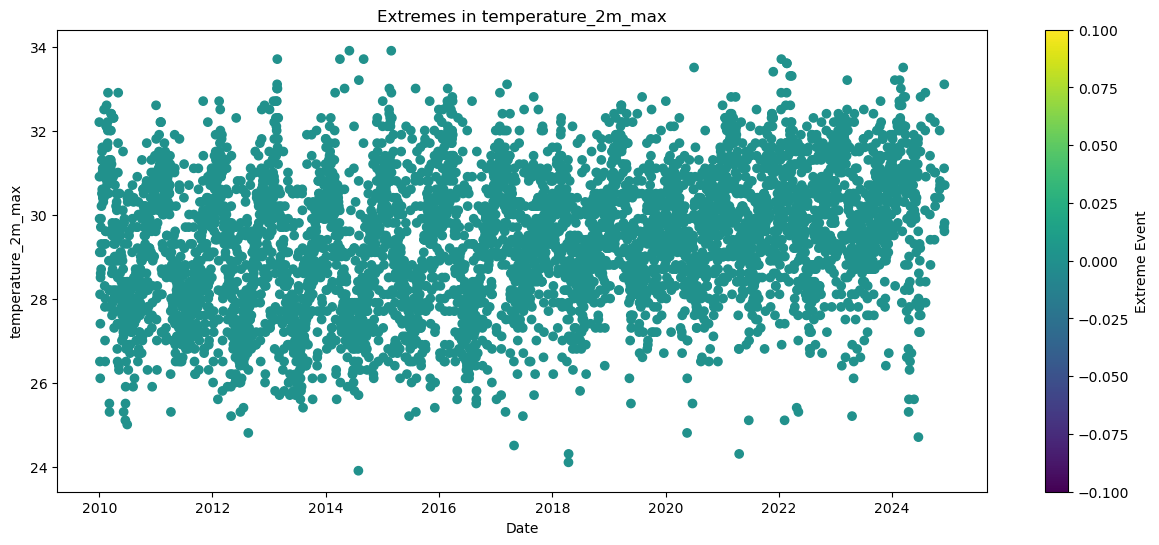


Number of temperature_2m_max extreme events
0


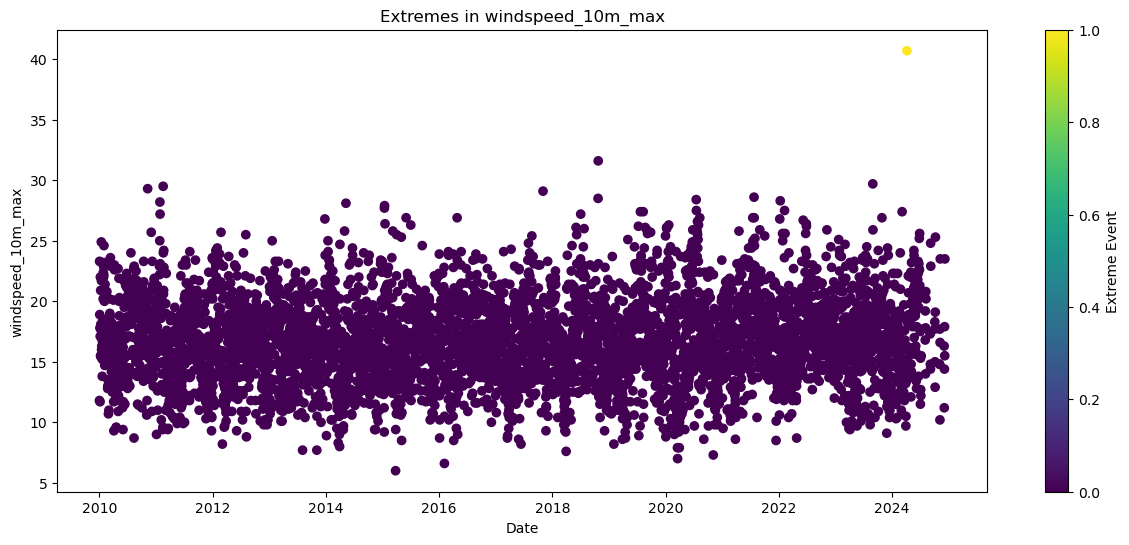


Number of windspeed_10m_max extreme events
1


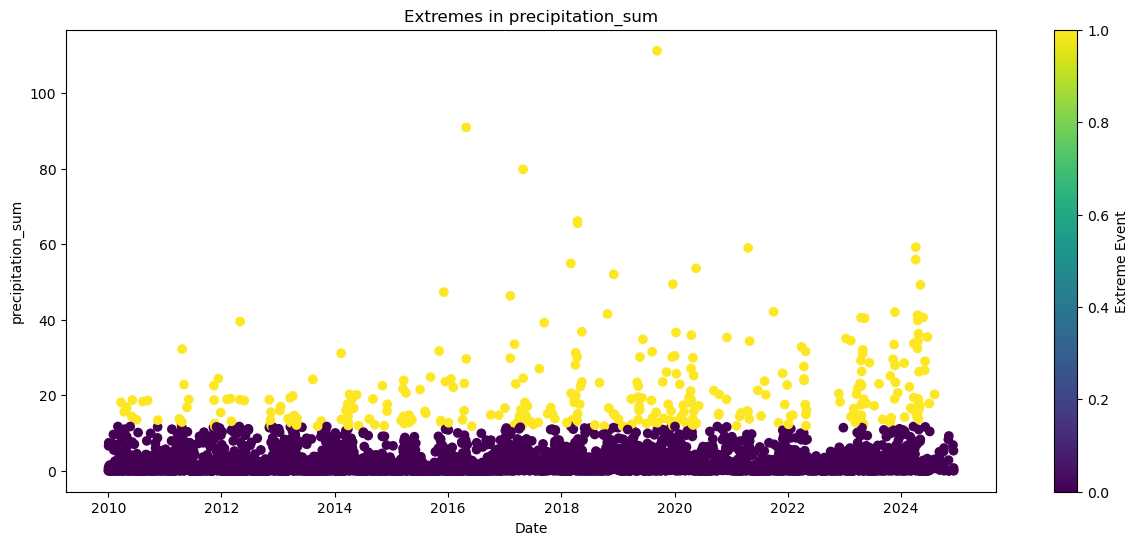


Number of precipitation_sum extreme events
322


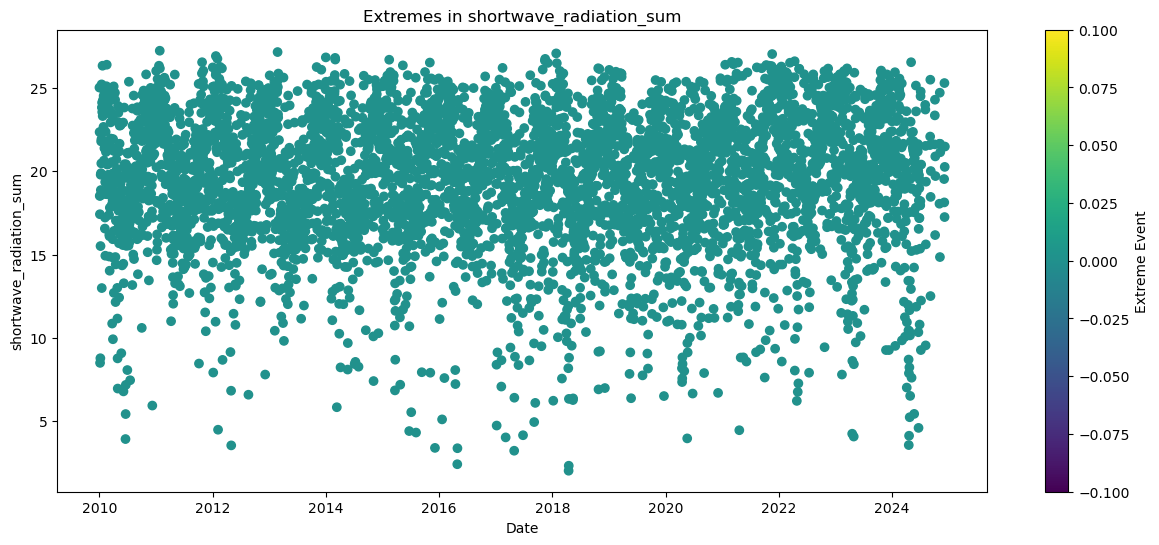


Number of shortwave_radiation_sum extreme events
0


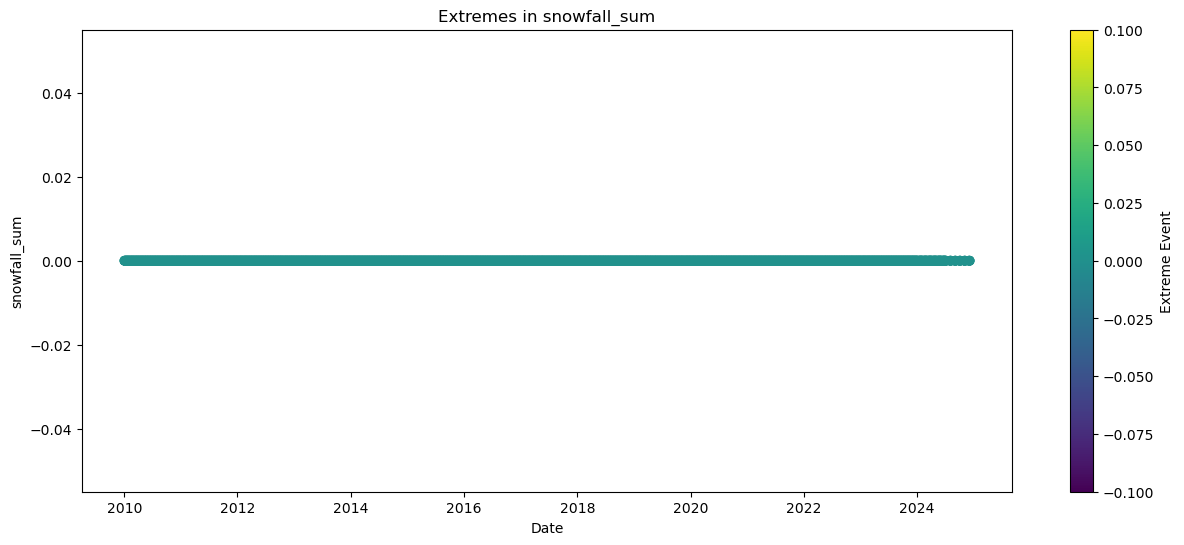


Number of snowfall_sum extreme events
0


Total number of extreme events detected: 322


In [13]:
# Function to plot anomalies
def plot_anomalies(data, feature):
    plt.figure(figsize=(15, 6))
    plt.scatter(data['time'], data[feature], c=data[f'{feature}_extreme'], cmap='viridis')
    plt.title(f'Extremes in {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.colorbar(label='Extreme Event')
    plt.show()

# Plot anomalies for each feature
for feature in ['temperature_2m_max', 'windspeed_10m_max', 'precipitation_sum', 
                'shortwave_radiation_sum', 'snowfall_sum']:
    plot_anomalies(data_with_extremes, feature)
    extreme_events_by_type = data_with_extremes[data_with_extremes[f'{feature}_extreme'] == 1][f'{feature}_extreme'].sum()
    print(f"\nNumber of {feature} extreme events")
    print(extreme_events_by_type)

# Calculate statistics on extreme events
total_extreme_events = data_with_extremes['extreme_event'].sum()

print(f"\n\nTotal number of extreme events detected: {total_extreme_events}")

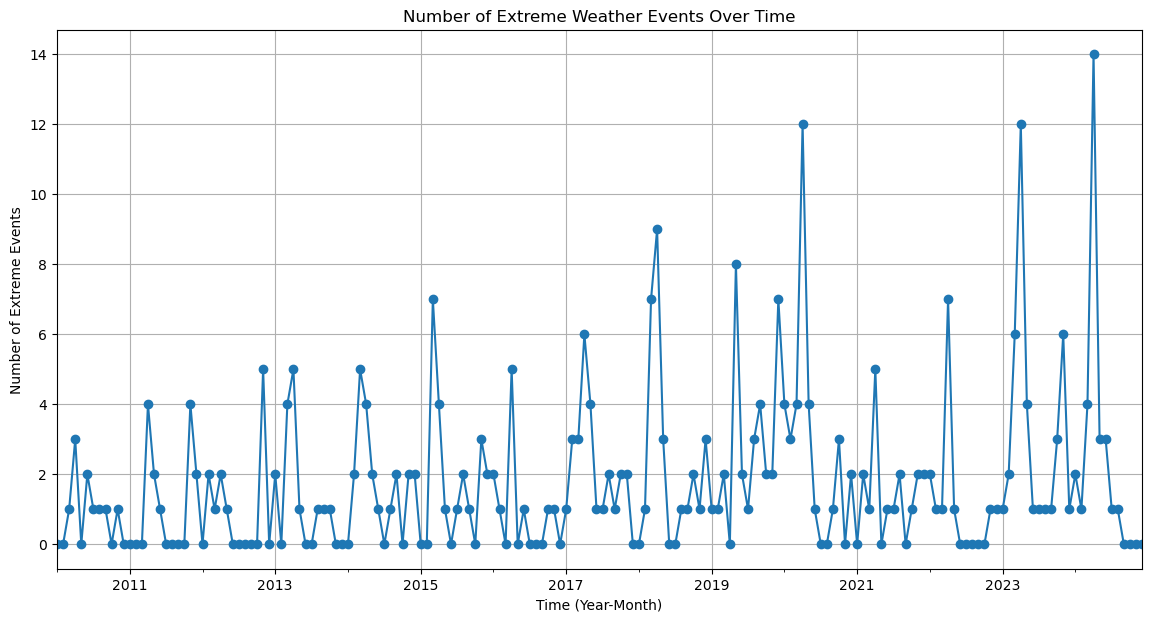

In [14]:
# Group the data by year and month to count the number of extreme events
data_with_extremes['year_month'] = data_with_extremes['time'].dt.to_period('M')
extreme_events_over_time = data_with_extremes.groupby('year_month')['extreme_event'].sum()

# Plot the number of extreme events over time
plt.figure(figsize=(14, 7))
extreme_events_over_time.plot(kind='line', marker='o')
plt.title('Number of Extreme Weather Events Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Extreme Events')
plt.grid(True)
plt.show()

In [15]:
data_with_extremes.extreme_event.value_counts(normalize=True)

extreme_event
0    0.939257
1    0.060743
Name: proportion, dtype: float64

In [16]:
data_with_extremes['hour'] = data_with_extremes['time'].dt.hour

X = data_with_extremes.drop(columns=['extreme_event', 'time', 'sunrise', 'sunset', 'country', 'city', 'year_month', 
                                     'latitude', 'longitude'])
X = X.drop(columns=['temperature_2m_max_extreme', 'windspeed_10m_max_extreme', 'precipitation_sum_extreme', 
                'shortwave_radiation_sum_extreme', 'snowfall_sum_extreme'])

In [17]:
X.columns

Index(['weathercode', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean',
       'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipitation_hours', 'windspeed_10m_max',
       'windgusts_10m_max', 'winddirection_10m_dominant',
       'et0_fao_evapotranspiration', 'elevation', 'hour'],
      dtype='object')

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-2.12596631,  1.78902399,  1.24251032, ...,  1.41569244,
         0.        ,  0.        ],
       [ 0.40513923,  1.97816042,  1.74458636, ...,  1.65840862,
         0.        ,  0.        ],
       [ 0.79454008,  0.71725085,  1.05423181, ...,  0.40069752,
         0.        ,  0.        ],
       ...,
       [-2.12596631,  0.33897797, -1.51890787, ...,  0.22417666,
         0.        ,  0.        ],
       [ 0.30778902,  1.09552372, -1.58166737, ...,  0.0476558 ,
         0.        ,  0.        ],
       [ 0.30778902,  0.65420537, -1.26786985, ...,  0.01455814,
         0.        ,  0.        ]])

In [19]:
X_scaled.shape

(5301, 18)

In [20]:
def create_sequences(X, y, time_steps=7):
    """
    Create sequences of data points for time series prediction.
    
    Args:
    X (np.array): Input features, shape (n_samples, n_features)
    y (np.array): Target variable, shape (n_samples,)
    time_steps (int): Number of time steps to use for each sequence
    
    Returns:
    X_sequences (np.array): Sequences of input features, shape (n_sequences, time_steps, n_features)
    y_sequences (np.array): Corresponding target values, shape (n_sequences,)
    """
    n_samples, n_features = X.shape
    
    Xs, ys = [], []
    for i in range(n_samples - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    
    return np.array(Xs), np.array(ys)

X_sequences, y_sequences = create_sequences(X_scaled, data_with_extremes['extreme_event'].values)

# Print shapes to verify
print(f"Shape of X_sequences: {X_sequences.shape}")
print(f"Shape of y_sequences: {y_sequences.shape}")

print("\nFirst sequence in X_sequences:")
print(X_sequences[0])
print("\nCorresponding y value:")
print(y_sequences[0])

Shape of X_sequences: (5294, 7, 18)
Shape of y_sequences: (5294,)

First sequence in X_sequences:
[[-2.12596631e+00  1.78902399e+00  1.24251032e+00  1.78356091e+00
   1.45284163e+00  1.61170924e+00  1.55797620e+00  1.39917231e+00
  -4.72936670e-01 -4.72936670e-01  0.00000000e+00 -1.08239423e+00
  -1.42498312e+00 -1.45854641e+00 -1.50212178e+00  1.41569244e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.05139228e-01  1.97816042e+00  1.74458636e+00  2.00402112e+00
   1.48761097e+00  1.44400379e+00  1.47226633e+00  1.34340492e+00
  -3.90782901e-01 -3.90782901e-01  0.00000000e+00 -9.00979918e-01
   1.27746445e-02 -6.20522346e-01 -1.51825498e+00  1.65840862e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.94540080e-01  7.17250847e-01  1.05423181e+00  1.26915377e+00
   5.83608089e-01  7.31255590e-01  9.15152161e-01  2.38196608e-01
   4.30754793e-01  4.30754793e-01  0.00000000e+00  9.13163184e-01
   3.00326197e-01  6.22065066e-01 -1.56665456e+00  4.00697516e-01
   0.00000000e+00  0.00000000e+00]
 [ 4.

In [21]:
X_sequences = np.array(X_sequences, dtype=np.float32)
y_sequences = np.array(y_sequences, dtype=np.float32)

In [22]:
# Split the sequences into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42, shuffle=False)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Define the LSTM model
lstm_model = Sequential([
    Input(shape=(X_sequences.shape[1], X_sequences.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

In [23]:
# Train the model with class weights
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, shuffle=False, class_weight=class_weights)

Epoch 1/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7280 - loss: 0.4941 - mse: 0.1833 - val_accuracy: 0.6092 - val_loss: 0.6127 - val_mse: 0.2277
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7225 - loss: 0.4310 - mse: 0.1691 - val_accuracy: 0.6470 - val_loss: 0.5766 - val_mse: 0.2108
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7399 - loss: 0.3959 - mse: 0.1526 - val_accuracy: 0.6682 - val_loss: 0.5605 - val_mse: 0.2006
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7683 - loss: 0.3768 - mse: 0.1430 - val_accuracy: 0.6919 - val_loss: 0.5630 - val_mse: 0.1967
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7762 - loss: 0.3679 - mse: 0.1381 - val_accuracy: 0.7037 - val_loss: 0.5578 - val_mse: 0.1919
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7815 - loss: 0.3525 - mse: 0.1310 - val_accuracy: 0.7119 - val_loss: 0.5476 - val_mse: 0.1884
Epoch 7/20
212/212 ━━━━━━━━━━━━━━

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_mse = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test MSE: {test_mse}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8694 - loss: 0.3205 - mse: 0.0978 
Test Loss: 0.4466092884540558, Test Accuracy: 0.8177525997161865, Test MSE: 0.13429246842861176


<h2>CNN-LSTMs</h2>

In [25]:
# Function to split sequences into subsequences
def split_to_subsequences(X, subseq_length):
    """
    Reshape sequences into smaller subsequences for CNN-LSTM model.
    Parameters:
    - X: Input sequences (samples, timesteps, features)
    - subseq_length: The length of each subsequence
    Returns:
    - Reshaped array with subsequences
    """
    n_samples, timesteps, n_features = X.shape
    subseq_count = timesteps // subseq_length
    return X.reshape((n_samples, subseq_count, subseq_length, n_features))

subseq_length = 7
X_subsequences = split_to_subsequences(X_sequences, subseq_length)

In [26]:
X_subsequences.shape

(5294, 1, 7, 18)

In [27]:
X_subsequences = np.array(X_subsequences, dtype=np.float32)

In [28]:
# Split the sequences into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subsequences, y_sequences, test_size=0.2, random_state=42, shuffle=False)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Define the cnn_lstm_model
cnn_lstm_model = Sequential([
    Input(shape=(None, X_subsequences.shape[2], X_subsequences.shape[3])),
    TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

In [29]:
# Train the cnn_lstm_model with class weights
history = cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, shuffle=False, class_weight=class_weights)

Epoch 1/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8953 - loss: 0.5050 - mse: 0.1486 - val_accuracy: 0.6612 - val_loss: 0.5400 - val_mse: 0.1988
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7853 - loss: 0.3797 - mse: 0.1259 - val_accuracy: 0.7072 - val_loss: 0.5030 - val_mse: 0.1800
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8104 - loss: 0.3340 - mse: 0.1113 - val_accuracy: 0.7178 - val_loss: 0.5353 - val_mse: 0.1856
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8096 - loss: 0.3151 - mse: 0.1169 - val_accuracy: 0.7226 - val_loss: 0.5317 - val_mse: 0.1827
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8113 - loss: 0.3051 - mse: 0.1162 - val_accuracy: 0.7332 - val_loss: 0.5693 - val_mse: 0.1874
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8358 - loss: 0.2727 - mse: 0.1034 - val_accuracy: 0.7450 - val_loss: 0.5189 - val_mse: 0.1732
Epoch 7/20
212/212 ━━━━━━━━━━━━━━

In [30]:
# Evaluate the cnn_lstm_model on the test set
test_loss, test_accuracy, test_mse = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test MSE: {test_mse}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9097 - loss: 0.3457 - mse: 0.0764   
Test Loss: 0.4479047656059265, Test Accuracy: 0.8791312575340271, Test MSE: 0.0988636463880539


<h2>ConvLSTM</h2>

In [31]:
from tensorflow.keras.layers import ConvLSTM2D

In [33]:
X_sequences_reshaped = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], 6, 3, 1))  # Reshape 18 features to 6x3

# Split the dataMessagesPlaceholder
X_train, X_test, y_train, y_test = train_test_split(X_sequences_reshaped, y_sequences, test_size=0.2, random_state=42, shuffle=False)

# Define the ConvLSTM2D model
conv_lstm_model = Sequential([
    Input(shape=(X_sequences_reshaped.shape[1], X_sequences_reshaped.shape[2], X_sequences_reshaped.shape[3], X_sequences_reshaped.shape[4])),
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=False),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
conv_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

# Train the model
conv_lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.9131 - loss: 0.2769 - mse: 0.0810 - val_accuracy: 0.9178 - val_loss: 0.2070 - val_mse: 0.0596
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9443 - loss: 0.1615 - mse: 0.0445 - val_accuracy: 0.9254 - val_loss: 0.2058 - val_mse: 0.0584
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.9439 - loss: 0.1642 - mse: 0.0457 - val_accuracy: 0.9169 - val_loss: 0.2125 - val_mse: 0.0618
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.9432 - loss: 0.1678 - mse: 0.0466 - val_accuracy: 0.9197 - val_loss: 0.2096 - val_mse: 0.0612
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.9477 - loss: 0.1545 - mse: 0.0422 - val_accuracy: 0.9226 - val_loss: 0.2124 - val_mse: 0.0604
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9402 - loss: 0.1759 - mse: 0.0483 - val_accuracy: 0.9197 - val_loss: 0.2001 - val_mse: 0.0582
Epoch 7/20
265/265 ━━━━━━━━━

In [34]:
# Evaluate the conv_lstm_model on the test set
test_loss, test_accuracy, test_mse = conv_lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test MSE: {test_mse}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9501 - loss: 0.1555 - mse: 0.0413
Test Loss: 0.2169756293296814, Test Accuracy: 0.9178470373153687, Test MSE: 0.06242077425122261
